In [2]:
import tensorflow as tf


Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#import cv2
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model
import pandas as pd

In [6]:
images_dir = "resized/"

We define ResNet layer

In [83]:
resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(224, 224, 3)
)

resnet.trainable = False

In [84]:
input_layer_1 = Input(shape=(224,224,3))
input_layer_2 = Input(shape=(224,224,3))

#extracted_features_1 = resnet(input_layer_1)
#extracted_features_2 = resnet2(input_layer_2)

extracted_features_1 = Model(inputs=resnet.input, outputs=resnet.output, name='resnet50_1')(input_layer_1)
extracted_features_2 = Model(inputs=resnet.input, outputs=resnet.output,  name='resnet50_2')(input_layer_2)

merge = concatenate([extracted_features_1, extracted_features_2])

x = tf.keras.layers.Dense(1024, activation="relu")(merge)
x = tf.keras.layers.Dense(512, activation="relu")(x)

classification_output = tf.keras.layers.Dense(1, activation="sigmoid")(x) # softmax

model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs = classification_output)

In [85]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(
    optimizer='adam',
    #optimizer=opt,
    loss='binary_crossentropy',
    metrics = ['accuracy']
)

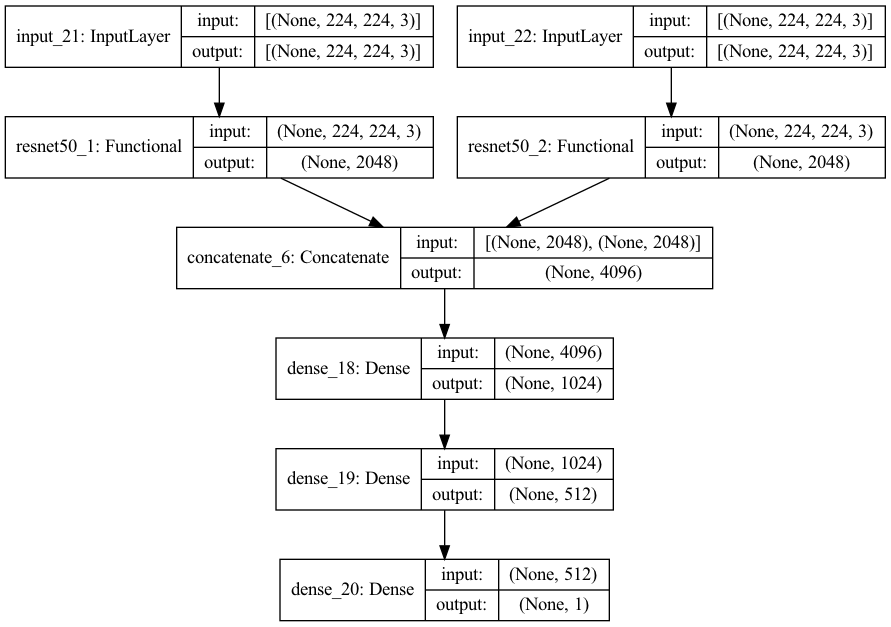

In [86]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [111]:
pairs = pd.read_csv("pairs2.csv")

In [112]:
pairs['Path 1'] = images_dir + pairs['Path 1']
pairs['Path 2'] = images_dir + pairs['Path 2']

To ensure our train and validation datasets are split, we use a stratified split from sklearn.

In [113]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(pairs, stratify=pairs["Label"], test_size=0.2)

In [114]:
def dataset_generator_train():
    def get_image_array(filename):
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string)
        image = tf.keras.applications.resnet50.preprocess_input(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        #tf.expand_dims(image, axis=0).shape.as_list()
        return image
    
    for pair, row in train_df.iterrows():
        image1 = get_image_array(row["Path 1"])
        image2 = get_image_array(row["Path 2"])
        #yield image1, row["Label"]
        yield (image1, image2), row["Label"]

In [115]:
def dataset_generator_val():
    def get_image_array(filename):
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string)
        image = tf.keras.applications.resnet50.preprocess_input(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        #tf.expand_dims(image, axis=0).shape.as_list()
        return image
    
    for pair, row in val_df.iterrows():
        image1 = get_image_array(row["Path 1"])
        image2 = get_image_array(row["Path 2"])
        #yield image1, row["Label"]
        yield (image1, image2), row["Label"]

In [116]:
batch_size = 200

In [117]:
dataset_train = tf.data.Dataset.from_generator(
    dataset_generator_train,
    output_signature = (
        (
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).batch(batch_size)

In [118]:
dataset_val = tf.data.Dataset.from_generator(
    dataset_generator_val,
    output_signature = (
        (
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).batch(batch_size)

In [119]:
num_epochs = 5

In [120]:
train_split = 0.8

In [121]:
val_split = 0.2

In [122]:
steps_per_epoch = (len(pairs) * train_split)//batch_size

In [123]:
validation_steps = (len(pairs) * val_split)//batch_size

In [ ]:
history = model.fit(
    dataset_train,
    epochs=num_epochs,
    validation_data = dataset_val,
    batch_size=batch_size,
    use_multiprocessing=True
)

Epoch 1/5
     40/Unknown - 207s 5s/step - loss: 0.6942 - accuracy: 0.4994

2022-11-15 15:46:33.938314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 259s 6s/step - loss: 0.6942 - accuracy: 0.4994 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/5
40/40 [==============================] - 254s 6s/step - loss: 0.6937 - accuracy: 0.5031 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/5
35/40 [=========================>....] - ETA: 25s - loss: 0.6937 - accuracy: 0.5000

# Unsorted code

In [ ]:
# from https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.2, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    #if shuffle:
    #    # Specify seed to always have the same split distribution between runs
    #    ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    
    return train_ds, val_ds#, test_ds # we are not using test split, could be removed

In [28]:
train, val = get_dataset_partitions_tf(dataset, len(pairs), train_split, val_split)

NameError: name 'get_dataset_partitions_tf' is not defined